# Level 1 — Clustering Pipeline 



## 0. Imports & Global Settings
Set random seeds and plotting style for reproducibility.


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  # For gap plot
from sklearn.cluster import KMeans  # For gap statistic

from src.bladder_proteomics.utils import load_data, validate_data
from src.bladder_proteomics.preprocessing import (
    log2_transform,
    median_center_rows,
    zscore_normalize,
)

from src.bladder_proteomics.dimensionality_reduction import apply_pca, apply_umap
from src.bladder_proteomics.k_selection import evaluate_k_selection_one
from src.bladder_proteomics.clustering import kmeans_cluster
from src.bladder_proteomics.plotting import (
    set_plot_style,
    plot_pca,
    plot_umap,
    plot_cluster_sizes,
)

np.random.seed(42)
set_plot_style(dpi=120)


## 1. Load & Align Proteomics and Metadata
Load proteomics and clinical metadata, and align them by Patient ID.


In [7]:
proteomics, metadata = load_data(
    "./data/proteomics.txt",
    "./data/metadata.csv",
    transpose=True
)

validate_data(proteomics)
validate_data(metadata)

# Align by Patient ID
common_ids = proteomics.index.intersection(metadata.index)
proteomics = proteomics.loc[common_ids]
metadata = metadata.loc[common_ids]

print(f"Number of patients after alignment: {len(common_ids)}")


Removed proteins with identical profiles: 9
Data shape (samples × features): (140, 3112)
Missing values: 0
Duplicate rows: 0 | Duplicate columns: 0
Data shape (samples × features): (140, 13)
Missing values: 0
Duplicate rows: 0 | Duplicate columns: 0
Number of patients after alignment: 140


## 2. Pipeline-specific helper functions

This part contains the functions to be tuned explicitly for optimizing pipeline. 

`select_representative_npc`
- For a fixed PCA embedding, iterate over different numbers of principal components.

- For each `n_pc`, run k-means clustering and compute both elbow-based and silhouette-based optimal k.

- If both elbow and silhouette agree on a same optimal k, select the `n_pc` with the highest silhouette score; otherwise mark the result as "unstable".

`select_top_m_by_cv`

- Apply log2 transformation to the proteomics matrix before compute CV.

- Compute CV for each protein across patients.

- Select the top m proteins with the highest CV for downstream PCA and clustering.
`gap_statistic`

- Compute the Gap statistic to estimate the optimal k.
- Require agreement across elbow, silhouette, and gap for stability.


In [8]:
def gap_statistic(X, k_max=20, B=50, random_state=42, n_init=10):
    """
    Compute Gap Statistic for k=1..k_max and return optimal k.
    """
    rng = np.random.default_rng(random_state)
    mins = X.min(axis=0)
    maxs = X.max(axis=0)

    wk = np.zeros(k_max)
    gap = np.zeros(k_max)
    se = np.zeros(k_max)

    for k in range(1, k_max + 1):
        km = KMeans(n_clusters=k, n_init=n_init, random_state=random_state)
        km.fit(X)
        wk[k - 1] = km.inertia_

        ref_wk = np.zeros(B)
        for b in range(B):
            X_ref = rng.uniform(mins, maxs, size=X.shape)
            km_ref = KMeans(n_clusters=k, n_init=n_init, random_state=random_state)
            km_ref.fit(X_ref)
            ref_wk[b] = km_ref.inertia_

        gap[k - 1] = ref_wk.mean() - wk[k - 1]
        se[k - 1] = ref_wk.std(ddof=1) / np.sqrt(B)

    optimal_k = k_max
    for k in range(1, k_max):
        if gap[k - 1] >= gap[k] - se[k]:
            optimal_k = k
            break

    return gap, se, wk, optimal_k


def select_representative_npc(
    pca_df: pd.DataFrame,
    pc_grid,
    k_max=20,
    gap_B=50,
    random_state=42,
):
    records = []

    for npc in pc_grid:
        X = pca_df.iloc[:, :npc].values
        res = evaluate_k_selection_one(pd.DataFrame(X), k_max=k_max)

        gap, se, wk, gap_k = gap_statistic(
            X,
            k_max=k_max,
            B=gap_B,
            random_state=random_state,
        )

        records.append({
            "n_pc": npc,
            "elbow_k": res["elbow_k"],
            "best_k": res["best_k_sil"],
            "best_sil": res["best_sil"],
            "gap_k": gap_k,
            "gap_at_k": float(gap[gap_k - 1]),
        })

    df = pd.DataFrame(records)

    consistent = df[(df["elbow_k"] == df["best_k"]) & (df["best_k"] == df["gap_k"])]

    if consistent.empty:
        return None, df

    best_row = consistent.loc[consistent["best_sil"].idxmax()]
    return best_row, df


def select_top_m_by_cv(X: pd.DataFrame, m: int) -> pd.DataFrame:
    X_log, _ = log2_transform(X)
    mean = X_log.mean(axis=0)
    std = X_log.std(axis=0)
    cv = std / mean.replace(0, np.nan)
    top_features = cv.sort_values(ascending=False).head(m).index
    return X_log[top_features]


## 3. Feature-selection Robustness

Evaluate clustering stability across different numbers of selected proteins (m).

- For each candidate number of selected proteins (m), the pipeline performs CV-based feature selection followed by z-score normalization.

- PCA is then fitted once up to a fixed maximum number of components (at most 20), and clustering stability is evaluated by scanning different n_pc values within this fixed PCA space.

- For each m, a representative (n_pc, k) pair is selected where elbow and silhouette criteria agree on the best K, and the explained variance of the selected PCs is recorded.



In [9]:
m_grid = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50] # m_grid is for hyperparameter search.
n_max=20 # n_max is a hyperparameter.
k_results = []

for m in m_grid:
    # feature selection
    X_m = select_top_m_by_cv(proteomics, m)
    X_m_scaled = zscore_normalize(X_m, axis=0)

    # FIXED PCA FIT (exactly like old code) 
    
    pca_nmax = min(n_max, X_m_scaled.shape[1])
    pca_full, pca_model = apply_pca(
        X_m_scaled,
        n_components=pca_nmax,
        return_model=True
    )

    # scan n_pc in the fixed PCA space
    pc_grid = list(range(2, pca_nmax + 1))
    k_max = pca_nmax

    best_row, df_npc = select_representative_npc(
        pca_full,
        pc_grid=pc_grid,
        k_max=k_max,
        gap_B=50,
        random_state=42
    )

    if best_row is None:
        k_results.append({
            "m": m,
            "status": "unstable",
        })
        continue

    explained = pca_model.explained_variance_ratio_
    var_explained_npc = explained[:int(best_row["n_pc"])].sum()

    k_results.append({
        "m": m,
        "n_pc": best_row["n_pc"],
        "k": best_row["best_k"],
        "best_sil": best_row["best_sil"],
        "gap_k": best_row["gap_k"],
        "gap_at_k": best_row["gap_at_k"],
        "var_explained": var_explained_npc,
        "status": "stable",
    })

k_summary = pd.DataFrame(k_results)
k_summary


,m,status,n_pc,k,best_sil,gap_k,gap_at_k,var_explained
0,5,unstable,NaN,NaN,NaN,NaN,NaN,NaN
1,10,unstable,NaN,NaN,NaN,NaN,NaN,NaN
2,15,unstable,NaN,NaN,NaN,NaN,NaN,NaN
3,20,stable,6.0,7.0,0.902679,7.0,955.213212,0.989161
4,25,stable,6.0,7.0,0.858757,7.0,1239.063849,0.960421
5,30,unstable,NaN,NaN,NaN,NaN,NaN,NaN
6,35,unstable,NaN,NaN,NaN,NaN,NaN,NaN
7,40,unstable,NaN,NaN,NaN,NaN,NaN,NaN
8,45,unstable,NaN,NaN,NaN,NaN,NaN,NaN
9,50,unstable,NaN,NaN,NaN,NaN,NaN,NaN


### 3.2 Final choice of m and k

- Only stable solutions where elbow, silhouette, and gap statistic agree on K are kept.
- Among these stable solutions, keep those explaining at least 80% variance, then select the one with the highest silhouette score.


In [10]:
# keep only stable rows
stable_df = k_summary[
    (k_summary["status"] == "stable") &
    (k_summary["var_explained"] >= 0.8)
].copy()

# select the row with maximum silhouette
best_final = stable_df.loc[stable_df["best_sil"].idxmax()]

best_final


m                        20
status               stable
n_pc                    6.0
k                       7.0
best_sil           0.902679
gap_k                   7.0
gap_at_k         955.213212
var_explained      0.989161
Name: 3, dtype: object

## 4. Visulization



### 4.1 Reconstruction of data

In [11]:
m_star = int(best_final["m"])
n_pc_star = int(best_final["n_pc"])
k_star = int(best_final["k"])

# feature selection
X_m = select_top_m_by_cv(proteomics, m_star)
X_m_scaled = zscore_normalize(X_m, axis=0)

# PCA fit to fixed 20 (same rule as before)
pca_nmax = min(n_max, X_m_scaled.shape[1])
pca_full, pca_model = apply_pca(
    X_m_scaled,
    n_components=pca_nmax,
    return_model=True
)

# clustering space
X_cluster = pca_full.iloc[:, :n_pc_star]

labels = kmeans_cluster(
    X_cluster,
    n_clusters=k_star,
    align_labels=True
)


### 4.1.1 Gap Statistic Plot
Visual check for the optimal k based on the selected PCA space.


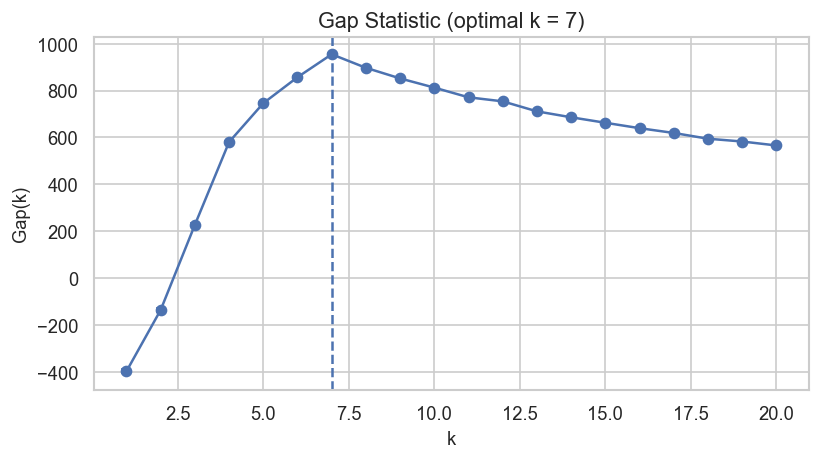

In [12]:
# Gap statistic plot for the selected PCA space
gap, se, wk, k_opt = gap_statistic(X_cluster.values, k_max=pca_nmax, B=50, random_state=42)

ks = np.arange(1, len(gap) + 1)
plt.figure(figsize=(7, 4))
plt.errorbar(ks, gap, yerr=se, marker='o', capsize=3)
plt.axvline(k_opt, linestyle='--')
plt.xlabel("k")
plt.ylabel("Gap(k)")
plt.title(f"Gap Statistic (optimal k = {k_opt})")
plt.grid(True)
plt.tight_layout()
plt.show()


### 4.2 PCA plot

(<Figure size 720x720 with 1 Axes>,
 <Axes: title={'center': 'PCA (m=20, n_pc=6, k=7)'}, xlabel='PC1', ylabel='PC2'>)

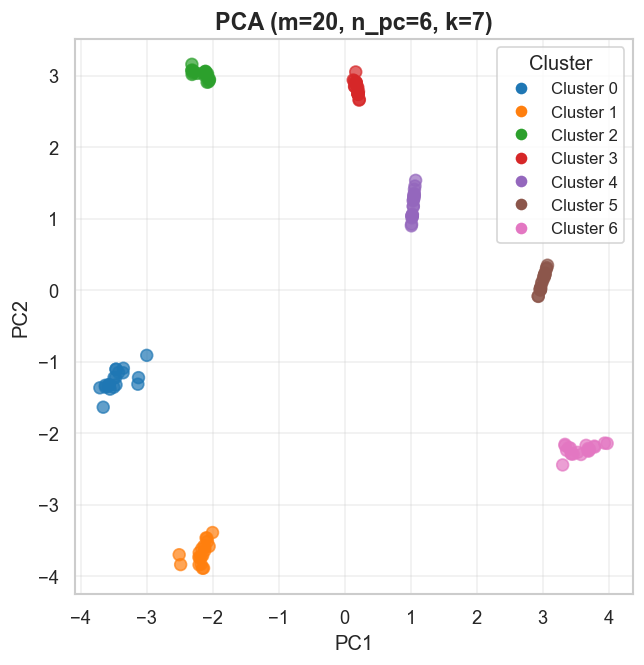

In [13]:
plot_pca(
    pca_full.iloc[:, :2],
    labels=labels,
    title=f"PCA (m={m_star}, n_pc={n_pc_star}, k={k_star})",
    figsize=(6, 6)
)


### 3.3 UMAP plot

/Users/jiayima/opt/anaconda3/envs/omics/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(<Figure size 720x720 with 1 Axes>,
 <Axes: title={'center': 'UMAP (m=20, n_pc=6, k=7)'}, xlabel='UMAP1', ylabel='UMAP2'>)

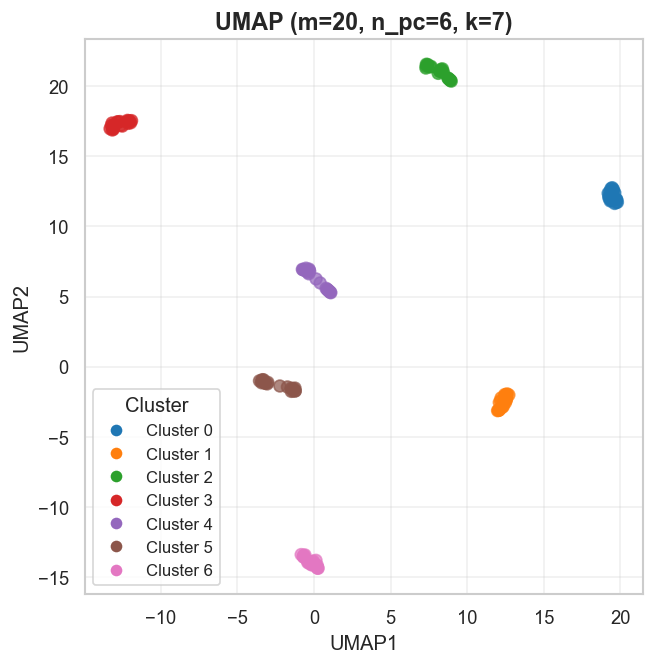

In [14]:
umap_2d = apply_umap(
    X_cluster,
    n_components=2,
    random_state=42
)


plot_umap(
    umap_2d,
    labels=labels,
    title=f"UMAP (m={m_star}, n_pc={n_pc_star}, k={k_star})",
    figsize=(6, 6),
)



### 4.4 Cluster Size Distribution

<Axes: title={'center': 'Cluster size distribution'}, xlabel='Number of patients'>

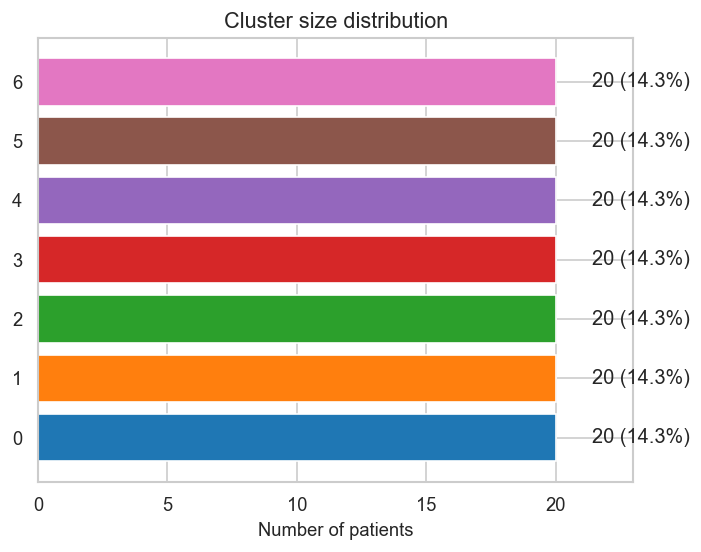

In [15]:
plot_cluster_sizes(
    pd.Series(labels, index=X_cluster.index),
    title="Cluster size distribution",
)


## 5. Metadata Evaluation
This is not a new clustering, just for evaluation or possible interpretation.

### 5.1 Alignment

In [16]:
metadata_aligned = metadata.loc[X_cluster.index].copy()
metadata_aligned["Cluster"] = labels

### 5.2 Numerical Metadata (Age, Tumor_Size etc.)

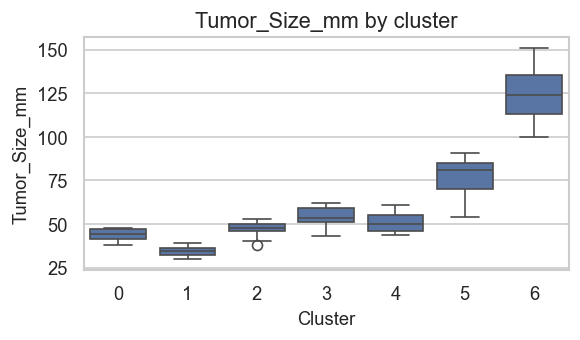

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

num_cols = ["Tumor_Size_mm"]
#  "Age", "Follow_up_Duration_months" seems non-relevant

for col in num_cols:
    plt.figure(figsize=(5, 3))
    sns.boxplot(
        data=metadata_aligned,
        x="Cluster",
        y=col
    )
    plt.title(f"{col} by cluster")
    plt.tight_layout()
    plt.show()


- There is a clear correlation between cluster and tumor size. 

Why clusters are sorted by tumor size for the tasks below? 

- Clusters are ordered by increasing median tumor size to impose a clinically interpretable progression axis, allowing systematic comparison of survival and treatment response patterns across clusters.

In [18]:
cluster_order = (
    metadata_aligned
    .groupby("Cluster")["Tumor_Size_mm"]
    .median()
    .sort_values()
    .index
    .tolist()
)

cluster_order


[1, 0, 2, 4, 3, 5, 6]

### 5.3 Categorical Metadata Histological_Grade, Metastasis, Survival etc.）

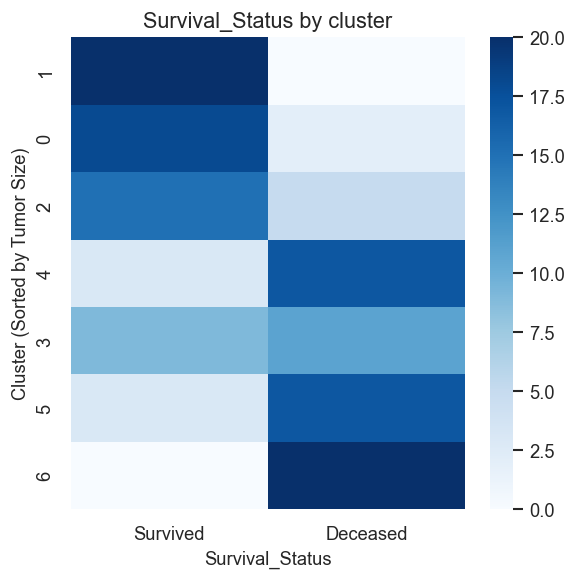

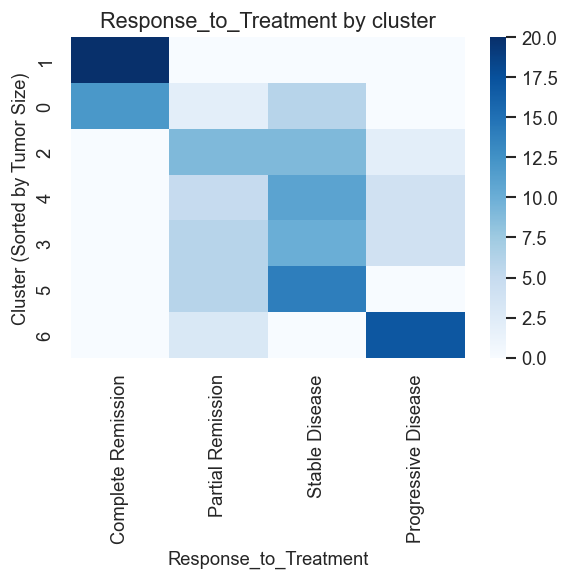

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt


cat_cols = [
    
    "Survival_Status",
    "Response_to_Treatment",
    
]
# "Histological_Grade", seems not very relevant
# "Metastasis", seems not very relevant
# "Treatment", seems not very relevant
# "Lymph_Node_Involvement", seems not very relevant

for col in cat_cols:
    ct = pd.crosstab(metadata_aligned["Cluster"], metadata_aligned[col])
    # display(ct)
    ct = ct.loc[cluster_order]
    if col=="Survival_Status":  
        ct = ct[["Survived", "Deceased"]]
    if col=="Response_to_Treatment":  
        ct = ct[["Complete Remission", "Partial Remission", "Stable Disease", "Progressive Disease"]]


    plt.figure(figsize=(5, 5))
    sns.heatmap(
        ct,
        cmap="Blues",
        fmt=".2f"
    )
    plt.title(f"{col} by cluster")
    plt.ylabel("Cluster (Sorted by Tumor Size)")
    plt.xlabel(f"{col}")
    plt.tight_layout()
    plt.show()



### Qualitative interpretation of the Metadata vs cluster

The survival heatmap shows a clear shift from predominantly survived patients in small-tumor clusters to predominantly deceased patients in large-tumor clusters, indicating strong clinical stratification by cluster.

The treatment-response heatmap reveals a parallel trend, with early clusters enriched for complete or partial remission and later clusters dominated by stable or progressive disease, supporting the clinical relevance of the identified subpopulations.
